## Imports

In [25]:
import tensorflow as tf
import tifffile as tiff
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import random
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import BinaryCrossentropy
from U_net import multi_unet_model


In [2]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
IMG_DIR_PATH = os.path.join(DATA_PATH, 'images')
LABELS_DIR_PATH = os.path.join(DATA_PATH, 'labels')
IMG_DIR_PATH

'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\data\\images'

### Questions

1) is there any other approach to avoid loading all data in memory?

In [3]:
img_file_paths = [ os.path.join(IMG_DIR_PATH, i) for i in os.listdir(IMG_DIR_PATH)]
img_file_paths.sort()
img_file_paths

['d:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\data\\images\\0.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\data\\images\\1.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\data\\images\\10.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\data\\images\\100.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\data\\images\\101.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\data\\images\\102.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\data\\images\\103.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\data\\images\\104.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\data\\images\\105.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\data\\images\\106.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentati

In [4]:
def normalize_image(image):
    """
    Normalize image to [0, 1] range.
    """
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)

    return normalized_image

In [5]:
images_arr = []

for i in img_file_paths:
    img = tiff.imread(i)
    images_arr.append(normalize_image(img))
    
images_arr = np.array(images_arr)

In [6]:
images_arr.min()

0.0

In [7]:
images_arr.shape

(306, 128, 128, 12)

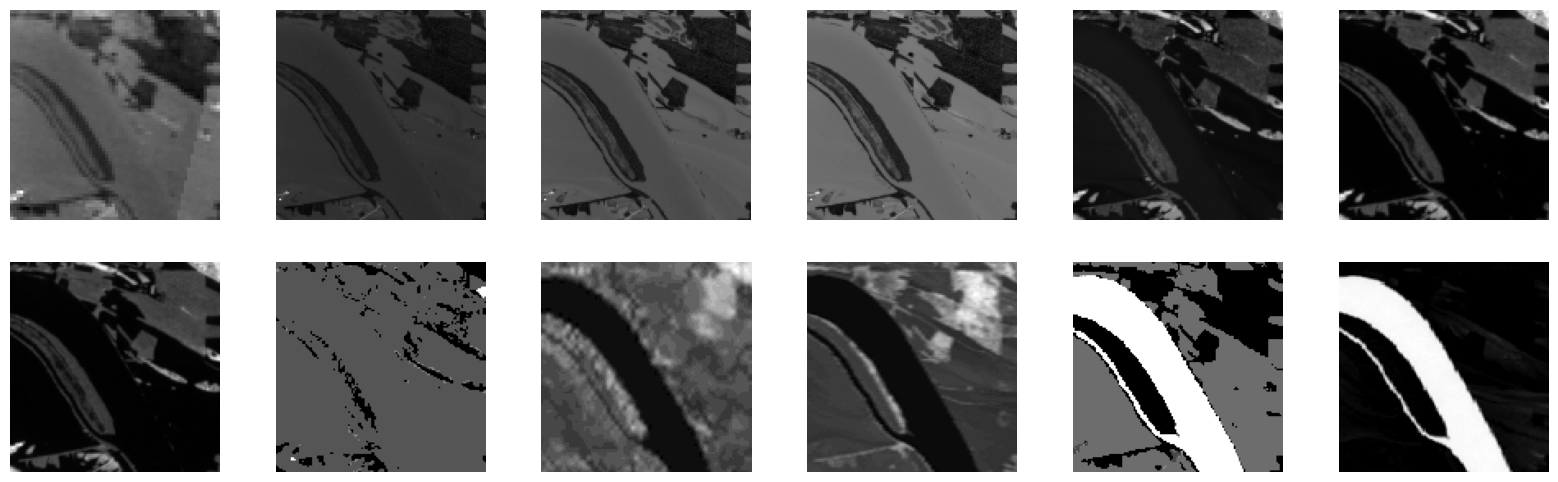

In [162]:

rand_num = random.randint(0, len(images_arr))
plt.figure(figsize=(20, 6))

for i in range(images_arr.shape[-1]):
    plt.subplot(2, 6, i+1)
    plt.imshow(images_arr[rand_num][:, :, i], cmap='gray')
    plt.axis('off')


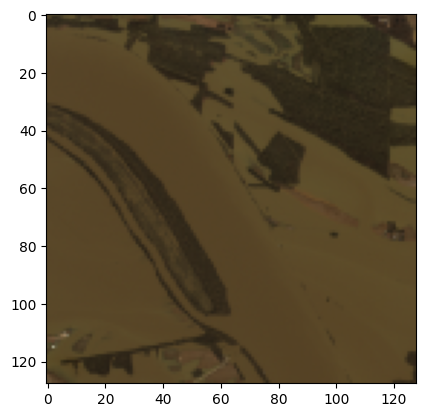

In [163]:
rgb_img = np.empty((images_arr.shape[1], images_arr.shape[2], 3))
rgb_img[:,:, 0] = images_arr[rand_num][:,:, 3]
rgb_img[:,:, 1] = images_arr[rand_num][:,:, 2]
rgb_img[:,:, 2] = images_arr[rand_num][:,:, 1]
plt.imshow(rgb_img)

- I have noticed that # of labels are greater than # of images

- and i decided to remove any file with label name different from the img name 

In [9]:
file_names_updated = [i for i in  os.listdir(LABELS_DIR_PATH) if '_' not in i]
file_names_updated.sort()
file_names_updated

['0.png',
 '1.png',
 '10.png',
 '100.png',
 '101.png',
 '102.png',
 '103.png',
 '104.png',
 '105.png',
 '106.png',
 '107.png',
 '108.png',
 '109.png',
 '11.png',
 '110.png',
 '111.png',
 '112.png',
 '113.png',
 '114.png',
 '115.png',
 '116.png',
 '117.png',
 '118.png',
 '119.png',
 '12.png',
 '120.png',
 '121.png',
 '122.png',
 '123.png',
 '124.png',
 '125.png',
 '126.png',
 '127.png',
 '128.png',
 '129.png',
 '13.png',
 '130.png',
 '131.png',
 '132.png',
 '133.png',
 '134.png',
 '135.png',
 '136.png',
 '137.png',
 '138.png',
 '139.png',
 '14.png',
 '140.png',
 '141.png',
 '142.png',
 '143.png',
 '144.png',
 '145.png',
 '146.png',
 '147.png',
 '148.png',
 '149.png',
 '15.png',
 '150.png',
 '151.png',
 '152.png',
 '153.png',
 '154.png',
 '155.png',
 '156.png',
 '157.png',
 '158.png',
 '159.png',
 '16.png',
 '160.png',
 '161.png',
 '162.png',
 '163.png',
 '164.png',
 '165.png',
 '166.png',
 '167.png',
 '168.png',
 '169.png',
 '17.png',
 '170.png',
 '171.png',
 '172.png',
 '173.png',
 '17

In [10]:
labels_arr = []

for i in file_names_updated:
    label_file_path = os.path.join(LABELS_DIR_PATH, i)
    label = plt.imread(label_file_path)
    labels_arr.append(label)
    
labels_arr = np.array(labels_arr)

In [11]:
label_binary = labels_arr.copy()
label_binary[label_binary > 0] = 1
label_binary[0]

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

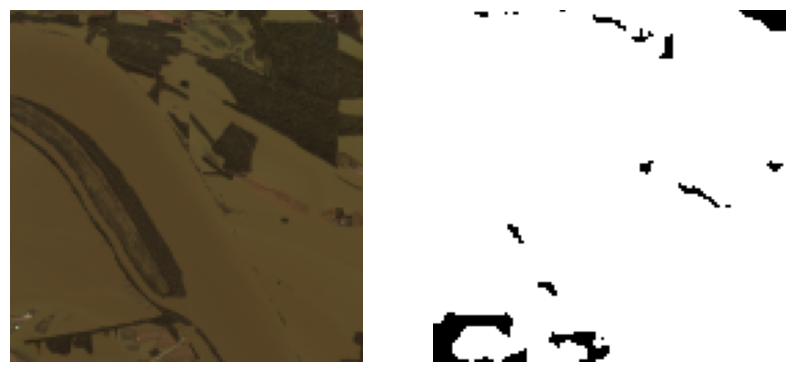

In [164]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(rgb_img)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(label_binary[rand_num], cmap='gray')
plt.show()

## Splitting data


In [14]:
X_train, X_test, y_train, y_test = train_test_split(images_arr, label_binary, test_size = 0.10, random_state = 42)

In [15]:
X_train.shape, y_train.shape

((275, 128, 128, 12), (275, 128, 128))

In [16]:
X_test.shape, y_test.shape

((31, 128, 128, 12), (31, 128, 128))

In [17]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [18]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS

(128, 128, 12)

In [19]:
model_1 = multi_unet_model(n_classes=1, IMG_HEIGHT=IMG_HEIGHT, 
                           IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [20]:
weights = [0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [21]:
# Create IoU metric
iou_metric = MeanIoU(2)
model_1.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[iou_metric, 'accuracy'])


In [22]:
history1 = model_1.fit(X_train, y_train, 
                    batch_size = 30, 
                    verbose=1, 
                    epochs=30, 
                    validation_split=0.1, 
                    shuffle=False)

Epoch 1/30
9/9 [==============================] - 15s 1s/step - loss: 0.5914 - mean_io_u: 0.3621 - accuracy: 0.6658 - val_loss: 0.4596 - val_mean_io_u: 0.3978 - val_accuracy: 0.7955
Epoch 2/30
9/9 [==============================] - 15s 2s/step - loss: 0.4685 - mean_io_u: 0.3621 - accuracy: 0.7246 - val_loss: 0.3830 - val_mean_io_u: 0.3978 - val_accuracy: 0.7955
Epoch 3/30
9/9 [==============================] - 17s 2s/step - loss: 0.4205 - mean_io_u: 0.3621 - accuracy: 0.7665 - val_loss: 0.3290 - val_mean_io_u: 0.3978 - val_accuracy: 0.8999
Epoch 4/30
9/9 [==============================] - 17s 2s/step - loss: 0.3935 - mean_io_u: 0.3621 - accuracy: 0.8487 - val_loss: 0.2881 - val_mean_io_u: 0.3978 - val_accuracy: 0.9321
Epoch 5/30
9/9 [==============================] - 19s 2s/step - loss: 0.3630 - mean_io_u: 0.3621 - accuracy: 0.8688 - val_loss: 0.2401 - val_mean_io_u: 0.3978 - val_accuracy: 0.9342
Epoch 6/30
9/9 [==============================] - 17s 2s/step - loss: 0.3269 - mean_io_u: 

In [64]:
label_pred = model_1.predict(X_test)
label_pred[label_pred >= 0.5] = 1
label_pred[label_pred < 0.5] = 0

1/1 [==============================] - 0s 133ms/step


In [71]:
len(label_pred)

31

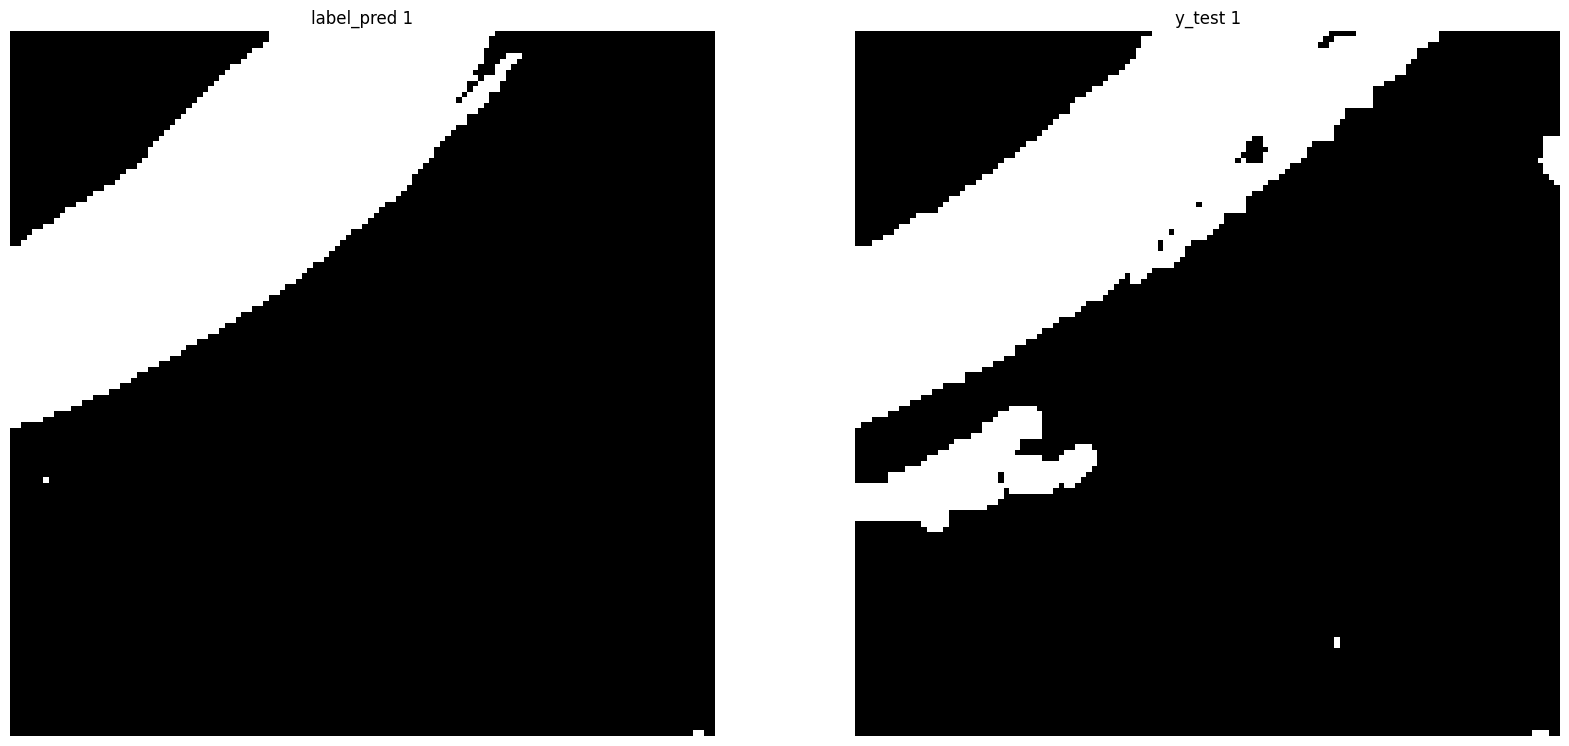

In [165]:
rand_num = random.randint(0, len(label_pred)-1)
plt.figure(figsize=(20, 14))
plt.subplot(121)
plt.axis('off')
plt.title(f'label_pred {rand_num}')
plt.imshow(label_pred[rand_num], cmap='gray')
plt.subplot(122)
plt.axis('off')
plt.title(f'y_test {rand_num}')
plt.imshow(y_test[rand_num], cmap='gray')

In [114]:
model_1.evaluate(X_test, y_test)

1/1 [==============================] - 0s 148ms/step - loss: 0.2185 - mean_io_u: 0.4093 - accuracy: 0.9020


[0.21850232779979706, 0.40930667519569397, 0.90203857421875]

In [50]:
X_test[1].shape

(128, 128, 12)

<Axes: >

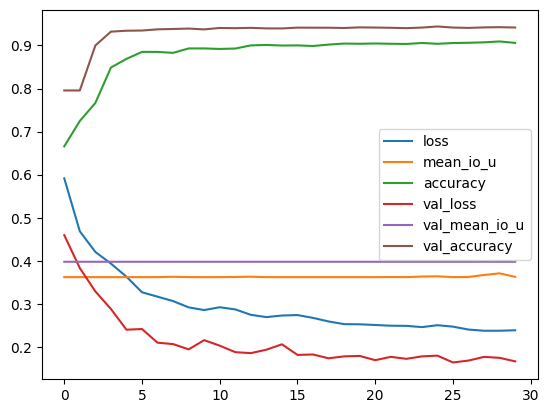

In [26]:
acc_loss_plot = pd.DataFrame(history1.history)
acc_loss_plot.plot()

In [31]:
model_2 = multi_unet_model(n_classes=1, IMG_HEIGHT=IMG_HEIGHT, 
                           IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [40]:
weights = [0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [41]:
model_2.compile(optimizer='adam', loss=[dice_loss], metrics=[iou_metric, 'accuracy'])

In [42]:
history2 = model_2.fit(X_train, y_train, 
                    batch_size = 50, 
                    verbose=1, 
                    epochs=30, 
                    validation_split=0.1, 
                    shuffle=False)

Epoch 1/30
5/5 [==============================] - 9s 1s/step - loss: 0.5875 - mean_io_u: 0.2612 - accuracy: 0.2895 - val_loss: 0.6604 - val_mean_io_u: 0.1024 - val_accuracy: 0.2045
Epoch 2/30
5/5 [==============================] - 8s 2s/step - loss: 0.5680 - mean_io_u: 0.1379 - accuracy: 0.2759 - val_loss: 0.6604 - val_mean_io_u: 0.1022 - val_accuracy: 0.2045
Epoch 3/30
5/5 [==============================] - 8s 2s/step - loss: 0.5680 - mean_io_u: 0.1379 - accuracy: 0.2759 - val_loss: 0.6604 - val_mean_io_u: 0.1022 - val_accuracy: 0.2045
Epoch 4/30
5/5 [==============================] - 8s 2s/step - loss: 0.5680 - mean_io_u: 0.1379 - accuracy: 0.2759 - val_loss: 0.6604 - val_mean_io_u: 0.1022 - val_accuracy: 0.2045
Epoch 5/30
5/5 [==============================] - 8s 2s/step - loss: 0.5680 - mean_io_u: 0.1379 - accuracy: 0.2759 - val_loss: 0.6604 - val_mean_io_u: 0.1022 - val_accuracy: 0.2045
Epoch 6/30
5/5 [==============================] - 8s 2s/step - loss: 0.5680 - mean_io_u: 0.1379

KeyboardInterrupt: 